# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Load data

In [3]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.shape

(891221, 366)

### Step 1: Drop not described features

- We get all attributes from "DIAS Attributes - Values 2017.xlsx" and "DIAS Information Levels - Attributes 2017.xlsx",  
Then parse the all the features not described in files.


In [5]:
DIAS_Attributes_list = pd.read_csv('./DIAS_Attributes_list.csv')

In [6]:
DIAS_Information_Levels_list = pd.read_csv('./DIAS_Information_Levels_list.csv')

In [7]:
features = azdias.columns
not_described_feature=[]
for i in range(0, azdias.shape[1]):
    feature = features[i]
    if feature.find("D19") >= 0:
        continue
    if feature.find("CJT_") >= 0:
        continue
    if feature.find("KBA") >= 0:
        continue
    if feature not in DIAS_Attributes_list.values and feature not in DIAS_Information_Levels_list.values:
        not_described_feature.append(feature)


In [8]:
print(not_described_feature)

['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11']


- For example,'ANZ_STATISTISCHE_HAUSHALTE' is similar to the 'ANZ_HAUSHALTE_AKTIV',which means 'number of households in the building',  
by boxplot and hist figure, we keep this feature.  
- At last we decide drop these features:  
'VHA', 'VK_ZG11', 'VERDICHTUNGSRAUM',  'CJT_KATALOGNUTZER', 'ALTER_KIND1', 'KOMBIALTER', 'EXTSEL992', 'LNR',  'UMFELD_JUNG', 'VHN',     'AKT_DAT_KL', 'VK_DISTANZ', 'RT_SCHNAEPPCHEN', 'ALTER_KIND3',  'RT_KEIN_ANREIZ', 'RT_UEBERGROESSE',  'UMFELD_ALT', 'STRUKTURTYP',       'D19_KONSUMTYP_MAX', 'ALTER_KIND4', 'ALTER_KIND2', 'EINGEFUEGT_AM',  'D19_LETZTER_KAUF_BRANCHE', 'VK_DHT4A', 'FIRMENDICHTE', 'GEMEINDETYP'    

In [9]:
not_described_feature = ['VHA', 'VK_ZG11', 'VERDICHTUNGSRAUM',  'CJT_KATALOGNUTZER', 'ALTER_KIND1', 'KOMBIALTER', 
                       'EXTSEL992', 'LNR',  'UMFELD_JUNG', 'VHN', 'AKT_DAT_KL', 'VK_DISTANZ', 'RT_SCHNAEPPCHEN',
                       'ALTER_KIND3',  'RT_KEIN_ANREIZ', 'RT_UEBERGROESSE',  'UMFELD_ALT', 'STRUKTURTYP', 
                       'D19_KONSUMTYP_MAX', 'ALTER_KIND4', 'ALTER_KIND2', 'EINGEFUEGT_AM',  'D19_LETZTER_KAUF_BRANCHE',
                       'VK_DHT4A', 'FIRMENDICHTE', 'GEMEINDETYP']

In [10]:
b = azdias['ANZ_STATISTISCHE_HAUSHALTE']
print(b.describe())

count    798073.000000
mean          7.599356
std          14.332201
min           0.000000
25%           1.000000
50%           3.000000
75%           9.000000
max         449.000000
Name: ANZ_STATISTISCHE_HAUSHALTE, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1c73f8ae088>,
 'caps': [<matplotlib.lines.Line2D at 0x1c73f985dc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c73f5ddec8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c73fa5ac08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c73faebf48>],
 'means': [<matplotlib.lines.Line2D at 0x1c73fabd5c8>]}

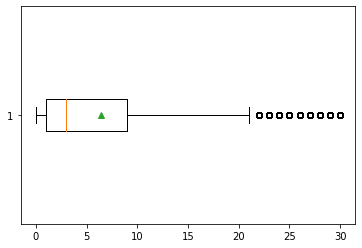

In [11]:
a = []
mean = b.mean()
for i in range(0,len(b)):
    if pd.notnull(b[i]) :
        tmp = b[i]
        if b[i] and b[i] > 30.0:
            tmp = 30.0
        a.append(tmp)
plt.boxplot(a, vert=False,showmeans=True)

798073


(array([340647., 146475., 107871.,  72061.,  39952.,  22389.,  13525.,
          9287.,   6911.,  38955.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

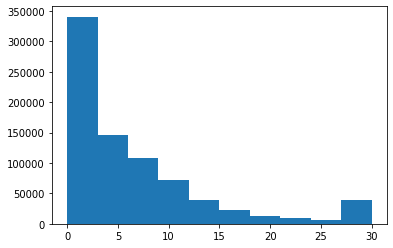

In [12]:
print(len(a))
plt.hist(a)

In [14]:
# drop features
azdias.drop(labels=not_described_feature, axis=1, inplace=True)

In [15]:
azdias.shape

(891221, 340)

In [16]:
obj_df = azdias.select_dtypes(include=['int64', 'float64']).copy()
obj_df

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,SOHO_KZ,TITEL_KZ,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1,NaN,NaN,NaN,3,1,2
1,-1,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,0.0,1.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,0.0,0.0,2,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,17.0,17.0,15.0,0.0,0.0,1.0,11.0,0.0,NaN,...,0.0,0.0,0.0,1,3.0,4.0,3.0,4,2,3
891217,-1,16.0,16.0,11.0,0.0,0.0,1.0,11.0,0.0,4.0,...,0.0,0.0,0.0,-1,6.0,9.0,5.0,6,1,2
891218,-1,17.0,17.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,...,0.0,0.0,0.0,1,NaN,5.0,7.0,4,2,2
891219,-1,0.0,20.0,7.0,0.0,1.0,1.0,5.0,0.0,4.0,...,0.0,0.0,0.0,2,1.0,9.0,5.0,5,1,1


In [17]:

obj_df = azdias.select_dtypes(include=['object']).copy()
obj_df

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,8,51,W
2,4C,4,24,W
3,2A,2,12,W
4,6B,6,43,W
...,...,...,...,...
891216,7A,7,41,W
891217,9D,9,51,W
891218,4C,4,24,W
891219,9D,9,51,W


### Step 2: Deal known values
- Transfer all unknown value in "DIAS_Feature_Summary.csv" into Nan  
We create a feature summary file, including features's data type, unknown value range.



In [18]:
# Load the unknown value in AZDIAS_Feature_Summary.csv
feat_info = pd.read_csv('DIAS_Feature_Summary.csv', sep=';')
feat_info.shape

(334, 3)

In [19]:
feat_info

,attribute,dtype,value
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0,9]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"
...,...,...,...
329,VERS_TYP,categorical,[-1]
330,WOHNDAUER_2008,ordinal,"[-1,0]"
331,WOHNLAGE,ordinal,"[-1,0]"
332,W_KEIT_KIND_HH,ordinal,"[-1,0]"


In [21]:
for col in range( feat_info.shape[0]):
    col_name = feat_info['attribute'][col]
    nalist = feat_info.iloc[col,2]
    nalist = nalist.replace('[','')
    nalist = nalist.replace(']','')
    nalist = nalist.split(',')
    if nalist == ['']:
        continue
    else:
        for nacode in nalist:
            # print( col_name)
            # print( feat_info['dtype'][col])
            # print( nalist)
            if feat_info['dtype'][col] != 'object':
                nacode = int(nacode)
                azdias.loc[azdias[col_name] == nacode, col_name] = np.nan

### Step 3: Deal Nan values
1. drop columns with count of null values bigger than 20%  
the following features are dropped：  
'AGER_TYP' 'ALTERSKATEGORIE_FEIN' 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_GESAMT_ONLINE_QUOTE_12'   
'D19_KONSUMTYP' 'D19_LOTTO' 'D19_SOZIALES' 'D19_TELKO_ONLINE_QUOTE_12' 'D19_VERSAND_ONLINE_QUOTE_12'    
'D19_VERSI_ONLINE_QUOTE_12' 'KK_KUNDENTYP'  
2. drop rows with count of null values bigger than 30%

(array([ 38.,   0.,   0.,  10., 146.,  13.,  58.,   2.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,   1.,   1.,
          3.,   0.,   0.,   2.,   3.,   1.,   3.,   4.,   3.,   1.,   5.,
          4.,   6.,   3.,   7.,   5.,   8.,   7.]),
 array([0.        , 0.0249779 , 0.04995579, 0.07493369, 0.09991158,
        0.12488948, 0.14986737, 0.17484527, 0.19982316, 0.22480106,
        0.24977895, 0.27475685, 0.29973475, 0.32471264, 0.34969054,
        0.37466843, 0.39964633, 0.42462422, 0.44960212, 0.47458001,
        0.49955791, 0.52453581, 0.5495137 , 0.5744916 , 0.59946949,
        0.62444739, 0.64942528, 0.67440318, 0.69938107, 0.72435897,
        0.74933686, 0.77431476, 0.79929266, 0.82427055, 0.84924845,
        0.87422634, 0.89920424, 0.92418213, 0.94916003, 0.97413792,
        0.99911582]),
 <a list of 40 Patch objects>)

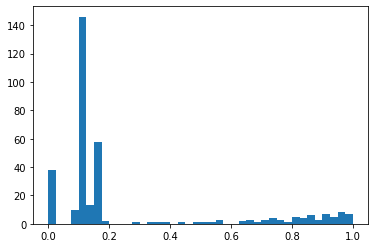

In [22]:
# calculate the percentage of missing values per feature
missing_per_column = azdias.isnull().mean()
plt.hist(missing_per_column, bins=40)

In [23]:
# features to be dropped have more than 20% missing values 
drop_missing_per_column = missing_per_column[missing_per_column > 0.2].index

# drop features
azdias.drop(labels=drop_missing_per_column, axis=1, inplace=True)

In [24]:
# print what features have been dropped
drop_missing_per_column

Index(['AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24'

(array([6.55032e+05, 3.19680e+04, 3.40110e+04, 1.08680e+04, 7.63000e+02,
        2.36000e+02, 4.04100e+03, 2.33000e+02, 1.34000e+02, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 5.96000e+02, 1.05850e+04, 1.11600e+03, 1.16280e+04,
        1.42940e+04, 7.43000e+02, 5.86500e+03, 2.46300e+03, 2.97000e+02,
        3.36000e+02, 1.30000e+02, 1.40000e+01, 4.30000e+01, 2.10000e+01,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.84000e+02,
        1.17000e+02, 1.90000e+01, 4.11300e+03, 5.50000e+02, 2.73000e+02,
        2.09000e+02, 3.20000e+01, 9.00000e+00, 1.20000e+01, 4.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 5.00000e+00, 1.70000e+01, 5.00

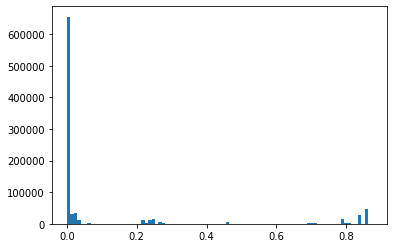

In [25]:
# calculate the percentage of missing values per individual
missing_per_row = azdias.isnull().sum(axis=1)

plt.hist(missing_per_row / azdias.shape[1], bins=90)

In [26]:
azdias = azdias[missing_per_row / azdias.shape[1] <= 0.3]
azdias.shape

(785211, 267)

### Step 4: Deal with Categorical values

- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.
- We drop some object type columns ,such as 'CAMEO_DEU_2015','CAMEO_DEUG_2015', Re-encode the 'OST_WEST_KZ' column.  
- We drop some columns those varibale levels are more than 10.

In [27]:
# obj_df = azdias.select_dtypes(include=['object']).copy()
# obj_df

In [28]:
# How many features are there of each data type?
feat_info = pd.read_csv('DIAS_Feature_Summary.csv', sep=';')
features = feat_info.groupby(['dtype'], as_index=False)[['attribute']].count()
features

,dtype,attribute
0,categorical,26
1,mixed,4
2,numeric,10
3,ordinal,294


In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
featDF = feat_info[['attribute','dtype']]
featDF = featDF.loc[featDF['dtype'] == 'categorical']

categoricals = featDF['attribute'].values
attList = list(set(azdias.columns.values).intersection(categoricals))
cat_azdias1 = azdias[attList]

uniqueValue = cat_azdias1.nunique().to_frame().reset_index(level=0, inplace=False)
uniqueValue.columns = ['index', 'nUnique']

binDF = uniqueValue.loc[uniqueValue['nUnique'] <= 2]
mulDF = uniqueValue.loc[uniqueValue['nUnique'] >2 ]

print(binDF)
print(mulDF)

               index  nUnique
2        OST_WEST_KZ        2
3   GREEN_AVANTGARDE        2
5        KONSUMZELLE        2
6            SOHO_KZ        2
9          ANREDE_KZ        2
11          DSL_FLAG        2
13     HH_DELTA_FLAG        2
16  UNGLEICHENN_FLAG        2
19          VERS_TYP        2
               index  nUnique
0      CJT_GESAMTTYP        6
1          FINANZTYP        6
4    LP_FAMILIE_FEIN       11
7        SHOPPER_TYP        4
8    GFK_URLAUBERTYP       12
10    LP_STATUS_FEIN       10
12   CAMEO_DEUG_2015       19
14  NATIONALITAET_KZ        3
15          ZABEOTYP        6
17   LP_FAMILIE_GROB        5
18    LP_STATUS_GROB        5
20    CAMEO_DEU_2015       45
21       GEBAEUDETYP        7


In [30]:
cat_azdias1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785211 entries, 1 to 891220
Data columns (total 22 columns):
CJT_GESAMTTYP       780701 non-null float64
FINANZTYP           785211 non-null float64
OST_WEST_KZ         785211 non-null object
GREEN_AVANTGARDE    785211 non-null int64
LP_FAMILIE_FEIN     754398 non-null float64
KONSUMZELLE         785206 non-null float64
SOHO_KZ             785211 non-null float64
SHOPPER_TYP         749154 non-null float64
GFK_URLAUBERTYP     780701 non-null float64
ANREDE_KZ           785211 non-null float64
LP_STATUS_FEIN      780701 non-null float64
DSL_FLAG            785211 non-null float64
CAMEO_DEUG_2015     781566 non-null object
HH_DELTA_FLAG       752453 non-null float64
NATIONALITAET_KZ    751910 non-null float64
ZABEOTYP            785211 non-null float64
UNGLEICHENN_FLAG    785211 non-null float64
LP_FAMILIE_GROB     754398 non-null float64
LP_STATUS_GROB      780701 non-null float64
VERS_TYP            749154 non-null float64
CAMEO_DEU_201

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.
#remove two object type columns
hotEncodeColumns = mulDF['index'].values.tolist()
hotEncodeColumns.remove('CAMEO_DEU_2015')
hotEncodeColumns.remove('CAMEO_DEUG_2015')
hotEncodeColumns.append('OST_WEST_KZ')

#remove those varibale levels are more than 10
hotEncodeColumns.remove('GFK_URLAUBERTYP')
hotEncodeColumns.remove('LP_STATUS_FEIN')
hotEncodeColumns.remove('LP_FAMILIE_FEIN')
print(hotEncodeColumns)


#re encode OST_WEST_KZ param
if azdias['OST_WEST_KZ'].unique().dtype == 'int64' :
    print("already set OST_WEST_KZ columns to int64 ")
else:
    azdias['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
    azdias['OST_WEST_KZ'].unique()

['CJT_GESAMTTYP', 'FINANZTYP', 'SHOPPER_TYP', 'NATIONALITAET_KZ', 'ZABEOTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'GEBAEUDETYP', 'OST_WEST_KZ']


In [32]:
encode_azdias1 = azdias[hotEncodeColumns]
encode_azdias1 = encode_azdias1.applymap(str)
encode_azdias1 = pd.get_dummies(encode_azdias1)
encode_azdias1 = encode_azdias1.apply(pd.to_numeric)
encode_azdias1.shape

(785211, 49)

### Step 5: Deal with Mixed type features
There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

We drop 'PRAEGENDE_JUGENDJAHRE' and create 'IS_MAINSTREAM','REGION' columns, they get mainstream and region info.  
We drop 'CAMEO_INTL_2015'and create 'HOUSEHOLD_WEALTH','HOUSEHOLD_LIFE_STAGE' columns ,these two colums get wealth and life stage info.  
And we drop all other mixed type columns,for most of the info are contained by other variables.  
eg. LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB contains age level,salary level and household type,we can see many columns contain these info.  

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# 
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()
# Mainstream :1  Avantgarde:2
row_indexer = azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14])
azdias.loc[row_indexer,'IS_MAINSTREAM']=1
row_indexer = azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15])
azdias.loc[row_indexer,'IS_MAINSTREAM']=2

# E : 1 W : 2 E+W:3
row_indexer = azdias['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13])
azdias.loc[row_indexer, 'REGION']=1
row_indexer = azdias['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11])
azdias.loc[row_indexer, 'REGION']=2
row_indexer = azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15])
azdias.loc[row_indexer,'REGION']=3

azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [34]:
azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,UNGLEICHENN_FLAG,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,IS_MAINSTREAM,REGION
1,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,...,1.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0,1.0,3.0
2,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,...,0.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0,2.0,3.0
3,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2,...,0.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0,1.0,3.0
4,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6,...,0.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0,1.0,3.0
5,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,8C,8,...,0.0,2.0,6.0,9.0,7.0,4.0,2.0,1.0,1.0,3.0


In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# create new column 'HOUSEHOLD_WEALTH'

azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].fillna(0)
azdias.loc[azdias['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'HOUSEHOLD_WEALTH']=1
azdias.loc[azdias['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'HOUSEHOLD_WEALTH']=2
azdias.loc[azdias['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'HOUSEHOLD_WEALTH']=3
azdias.loc[azdias['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'HOUSEHOLD_WEALTH']=4
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'HOUSEHOLD_WEALTH']=5

# create new column 'HOUSEHOLD_LIFE_STAGE'
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'HOUSEHOLD_LIFE_STAGE']=1
azdias.loc[azdias['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'HOUSEHOLD_LIFE_STAGE']=2
azdias.loc[azdias['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'HOUSEHOLD_LIFE_STAGE']=3
azdias.loc[azdias['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'HOUSEHOLD_LIFE_STAGE']=4
azdias.loc[azdias['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'HOUSEHOLD_LIFE_STAGE']=5


# drop original column
azdias=azdias.drop('CAMEO_INTL_2015',axis=1)

### Step 6: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [36]:
#drop object columns except OST_WEST_KZ
azdias = azdias.drop(['CAMEO_DEU_2015','CAMEO_DEUG_2015'],axis=1)

#drop mul-level >10 columns
# GFK_URLAUBERTYP  LP_STATUS_FEIN LP_FAMILIE_FEIN
azdias = azdias.drop(['GFK_URLAUBERTYP','LP_STATUS_FEIN','LP_FAMILIE_FEIN'],axis=1)


azdias = pd.concat([azdias, encode_azdias1], axis=1)
print(azdias.shape)

(785211, 313)


#### Step 7: Create a Clean Function  
We'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below   
to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at  
the customer data in Part1 Customer Segmentation Report, we can just run this function on that DataFrame to get the trimmed  
dataset in a single step.

In [71]:

not_described_feature = ['VHA', 'VK_ZG11', 'VERDICHTUNGSRAUM',  'CJT_KATALOGNUTZER', 'ALTER_KIND1', 'KOMBIALTER', 
                       'EXTSEL992', 'LNR',  'UMFELD_JUNG', 'VHN', 'AKT_DAT_KL', 'VK_DISTANZ', 'RT_SCHNAEPPCHEN',
                       'ALTER_KIND3',  'RT_KEIN_ANREIZ', 'RT_UEBERGROESSE',  'UMFELD_ALT', 'STRUKTURTYP', 
                       'D19_KONSUMTYP_MAX', 'ALTER_KIND4', 'ALTER_KIND2', 'EINGEFUEGT_AM',  'D19_LETZTER_KAUF_BRANCHE',
                       'VK_DHT4A', 'FIRMENDICHTE', 'GEMEINDETYP']
df_feat_info = pd.read_csv('DIAS_Feature_Summary.csv', sep=';')

def clean_data(df, df_feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    azdias = df
    # drop not described features
    azdias.drop(labels=not_described_feature, axis=1, inplace=True)
    print("[1.0 drop not described features]")
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in range( df_feat_info.shape[0]):
        col_name = df_feat_info['attribute'][col]
        nalist = df_feat_info.iloc[col,2]
        nalist = nalist.replace('[','')
        nalist = nalist.replace(']','')
        nalist = nalist.split(',')
        if nalist == ['']:
            continue
        else:
            for nacode in nalist:
                # print( col_name)
                # print( feat_info['dtype'][col])
                # print( nalist)
                if df_feat_info['dtype'][col] != 'object':
                    nacode = int(nacode)
                    azdias.loc[azdias[col_name] == nacode, col_name] = np.nan
    print("[1.1 convert missing value codes into Nans]")
    
    azdias = azdias.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)
    #drop object columns except OST_WEST_KZ
    azdias = azdias.drop(['CAMEO_DEU_2015','CAMEO_DEUG_2015'],axis=1)
    
    #drop mul-level >10 columns
    # GFK_URLAUBERTYP  LP_STATUS_FEIN LP_FAMILIE_FEIN
    azdias = azdias.drop(['GFK_URLAUBERTYP','LP_STATUS_FEIN','LP_FAMILIE_FEIN'],axis=1)
    
    print("1.2 remove selected columns and rows")
    # select, re-encode, and engineer column values.
    naCount = pd.DataFrame(azdias.shape[1] - azdias.count(axis=1))
    naCount.columns = ['naCount']
    SplitNum =20
    naCount1 = naCount[naCount['naCount'] < SplitNum]
    naCount2 = naCount[naCount['naCount'] >=SplitNum]
    azdias1 = azdias.iloc[naCount1.index, :]
    azdias2 = azdias.iloc[naCount2.index, :]

    featDF = feat_info[['attribute','dtype']]
    featDF = featDF.loc[featDF['dtype'] == 'categorical']

    categoricals = featDF['attribute'].values
    attList = list(set(azdias1.columns.values).intersection(categoricals))
    cat_azdias1 = azdias1[attList]

    uniqueValue = cat_azdias1.nunique().to_frame().reset_index(level=0, inplace=False)
    uniqueValue.columns = ['index', 'nUnique']

    binDF = uniqueValue.loc[uniqueValue['nUnique'] <= 2]
    mulDF = uniqueValue.loc[uniqueValue['nUnique'] >2 ]
    
    # Re-encode categorical variable(s) to be kept in the analysis.

    hotEncodeColumns = mulDF['index'].values.tolist()
    hotEncodeColumns.append('OST_WEST_KZ')

    #re encode OST_WEST_KZ param
    if azdias1['OST_WEST_KZ'].unique().dtype == 'int64' :
        print("already set OST_WEST_KZ columns to int64 ")
    else:
        azdias1['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
        azdias1['OST_WEST_KZ'].unique()
    
    encode_azdias1 = azdias1[hotEncodeColumns]
    encode_azdias1 = encode_azdias1.applymap(str)
    encode_azdias1 = pd.get_dummies(encode_azdias1)
    encode_azdias1 = encode_azdias1.apply(pd.to_numeric)
    print("[1.3 re encode some columns]")
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # 
    azdias1['PRAEGENDE_JUGENDJAHRE'].value_counts()
    # Mainstream :1  Avantgarde:2
    row_indexer = azdias1['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14])
    azdias1.loc[row_indexer,'IS_MAINSTREAM']=1
    row_indexer = azdias1['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15])
    azdias1.loc[row_indexer,'IS_MAINSTREAM']=2

    # E : 1 W : 2 E+W:3
    row_indexer = azdias1['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13])
    azdias1.loc[row_indexer, 'REGION']=1
    row_indexer = azdias1['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11])
    azdias1.loc[row_indexer, 'REGION']=2
    row_indexer = azdias1['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15])
    azdias1.loc[row_indexer,'REGION']=3
    azdias1 = azdias1.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # create new column 'HOUSEHOLD_WEALTH'
    azdias1['CAMEO_INTL_2015'] = azdias1['CAMEO_INTL_2015'].fillna(0)
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'HOUSEHOLD_WEALTH']=1
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'HOUSEHOLD_WEALTH']=2
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'HOUSEHOLD_WEALTH']=3
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'HOUSEHOLD_WEALTH']=4
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'HOUSEHOLD_WEALTH']=5

    # create new column 'HOUSEHOLD_LIFE_STAGE'
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'HOUSEHOLD_LIFE_STAGE']=1
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'HOUSEHOLD_LIFE_STAGE']=2
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'HOUSEHOLD_LIFE_STAGE']=3
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'HOUSEHOLD_LIFE_STAGE']=4
    azdias1.loc[azdias1['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'HOUSEHOLD_LIFE_STAGE']=5
    # drop original column
    azdias1=azdias1.drop('CAMEO_INTL_2015',axis=1)
    
    print("[1.4 engineer some columns]")
    
    azdias1 = pd.concat([azdias1, encode_azdias1], axis=1)
    # calculate the percentage of missing values per feature
    missing_per_column = azdias.isnull().mean()
    # features to be dropped have more than 20% missing values 
    drop_missing_per_column = missing_per_column[missing_per_column > 0.2].index
    azdias_cleaned = azdias.drop(labels=drop_missing_per_column, axis=1, inplace=True)

    print("[1.5 return cleaned azdias dataframe]")
    return azdias_cleaned
    # Return the cleaned dataframe.

### Step 8.1: Apply Feature Scaling
- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

My strategy for imputer is to replace nans by the most frequent values in each column. For we can see that,the most frequent valuses are the least special value in those respects for analysis.

In [42]:
imp = Imputer(strategy='most_frequent', axis=1)
azdias_clean_trans = imp.fit_transform(azdias)
azdias_clean_df = pd.DataFrame(azdias_clean_trans, columns=azdias.columns)

# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_clean_trans = scaler.fit_transform(azdias_clean_trans)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Step 1: PCA
- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [43]:
# Apply PCA to the data.

pcaModel = PCA()
Azidas_pca = pcaModel.fit_transform(azdias_clean_trans)

In [46]:
# Investigate the variance accounted for by each principal component.
def parse_var_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


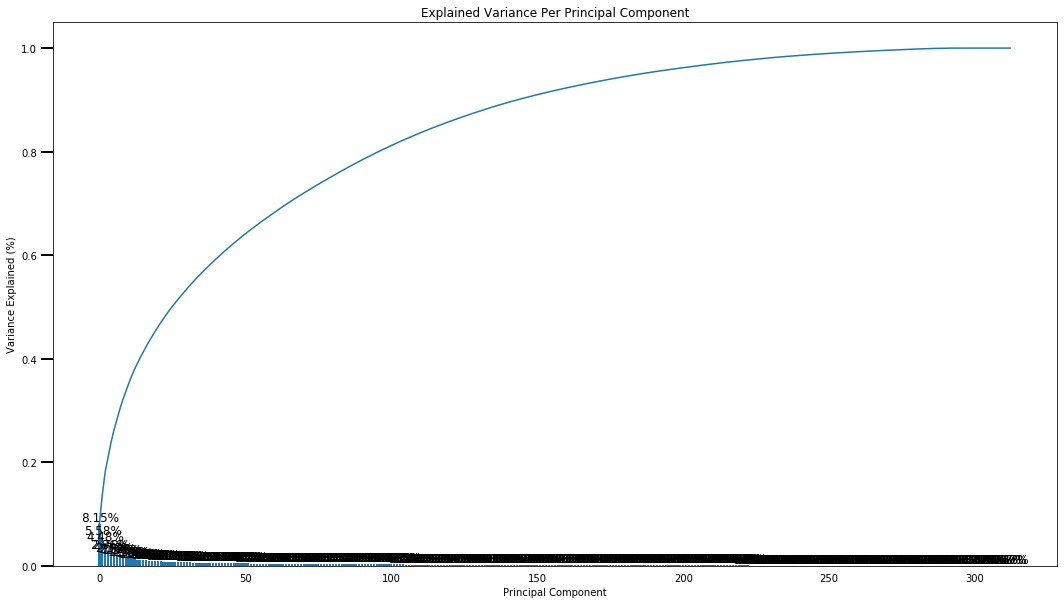

In [47]:
parse_var_plot(pcaModel)

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain
pca = PCA(n_components=150)
Azidas_pca = pca.fit_transform(azdias_clean_trans)

### Step 2：Interpret Principal Components

In [55]:
def interpetPCA(pca, df, dimOfInterest, showFeat):
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 5), columns = df.columns.values)

    # PCA explained variance per dimension
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])

    pcaDf = pd.concat([variance_ratios, components], axis = 1)

    #look at single dimension
    singleComp = components.iloc[dimOfInterest,:]
    topComp = singleComp.sort_values(ascending=False)[0:showFeat].to_frame().transpose()
    bottomComp = singleComp.sort_values(ascending=True)[0:showFeat].to_frame().transpose()
    singleComp = pd.concat([topComp, bottomComp], axis=1)
    print(topComp)
    print(bottomComp)
    ax = singleComp.plot(kind='bar', figsize=(10, 6))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

   KBA13_BAUMAX  KBA13_ANTG3  KBA13_ANTG4
0       0.14641      0.14629      0.14565
   PLZ8_ANTG1  KBA13_ANTG1  MOBI_REGIO
0    -0.15077      -0.1506    -0.14622


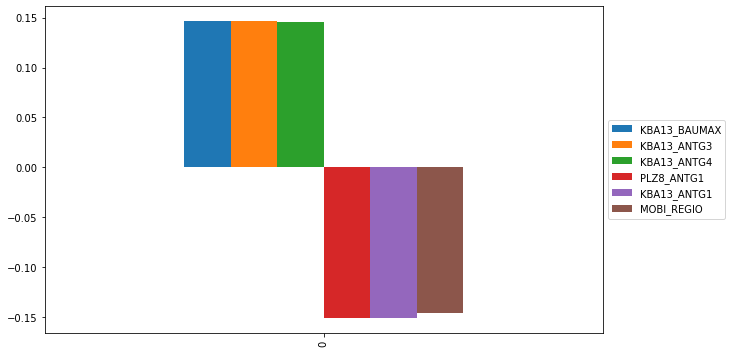

In [56]:
interpetPCA(pca, azdias_clean_df, 0, 3)

### Step 3：Clustering and Evaluation
In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [ ]:
# Over a number of different cluster counts...
centersOwn, scoresOwn = np.arange(10,18), []


for counter, clusters in enumerate(centersOwn):
    # run k-means clustering on the data and...
    kmeans = KMeans(clusters)
    model = kmeans.fit(Azidas_pca)
    # compute the average within-cluster distances.
    scoresOwn.append(model.inertia_)
    print("{}: clusters{} SSE{}".format(counter, clusters, model.inertia_ ))

0: clusters10 SSE180635815.66013038


In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centersOwn, scoresOwn, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')

In the range number 10-18, I choose 16 clusters for k-means model,  
because the average distance decrease is obiviously smaller than before.

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16)
model_az = kmeans.fit(Azidas_pca)
labels_az = model_az.predict(Azidas_pca)

### Step 4：Apply All Steps to the Customer Data

In [72]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

diff_customers_azdias = ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']

df_feat_info = pd.read_csv('DIAS_Feature_Summary.csv', sep=';')
# for customers three additional columns have to be dropped before cleaning
customers.drop(diff_customers_azdias, axis=1, inplace=True)

In [73]:
customers_cleaned = clean_data(customers, df_feat_info)

[1.0 drop not described features]
[1.1 convert missing value codes into Nans]
1.2 remove selected columns and rows


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

[1.3 re encode some columns]
[1.4 engineer some columns]
[1.5 return cleaned azdias dataframe]


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [14]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [15]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [35]:
mailout_train['RESPONSE'].vlaues

532

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [16]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [27]:
for i in range(0,mailout_train.columns.size):
    if mailout_train.columns[i] not in mailout_test.columns:
        print(mailout_test.columns[i])

ANREDE_KZ


In [29]:
print(mailout_train.shape)

(42962, 367)


In [30]:
print(mailout_test.shape)

(42833, 366)


In [31]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
